* PAPER - AN IMAGE IS WORTH 16X16 WORDS : TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE - [PDF](https://arxiv.org/pdf/2010.11929.pdf)
* PAPER - Escaping the Big Data Paradigm with Compact Transformers - [PDF](https://arxiv.org/pdf/2104.05704.pdf)

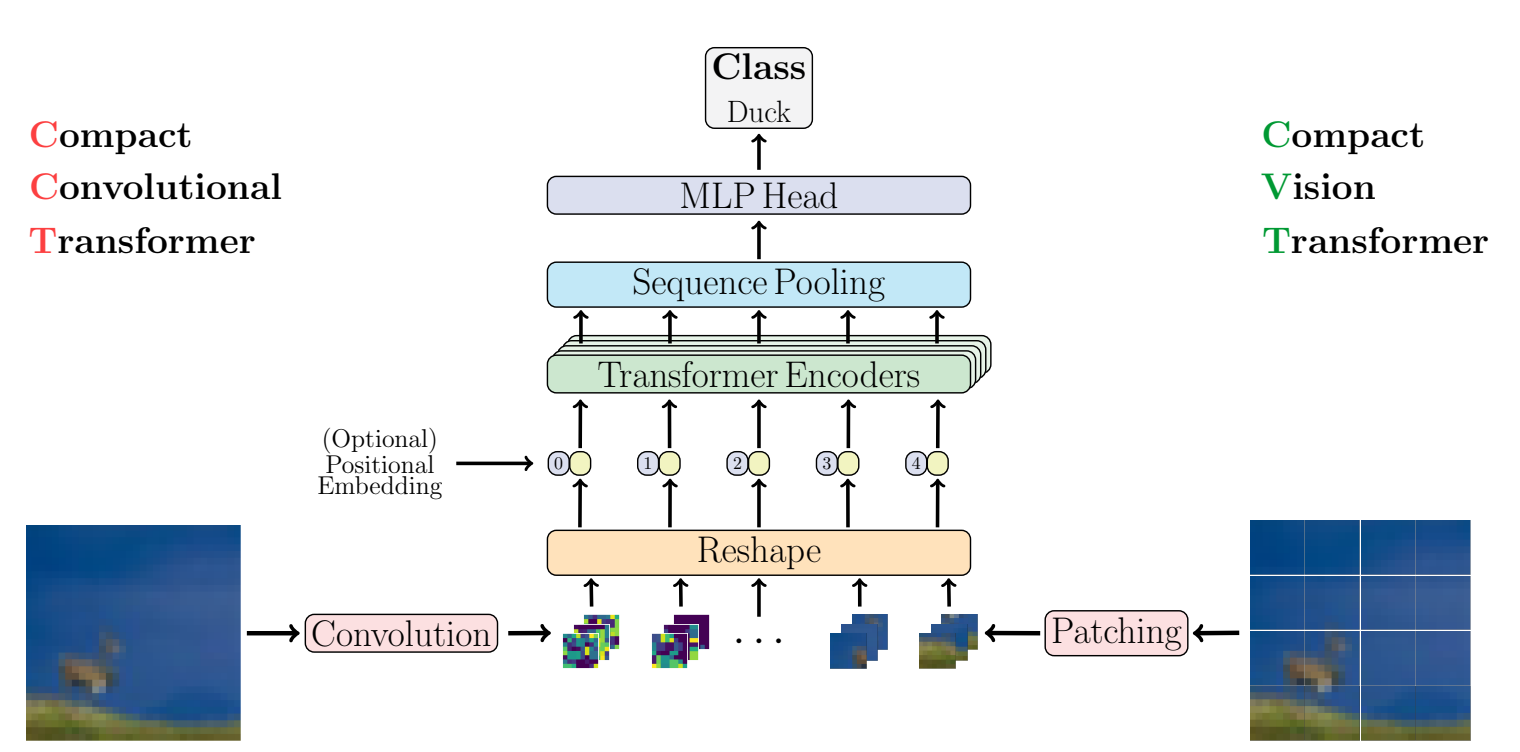

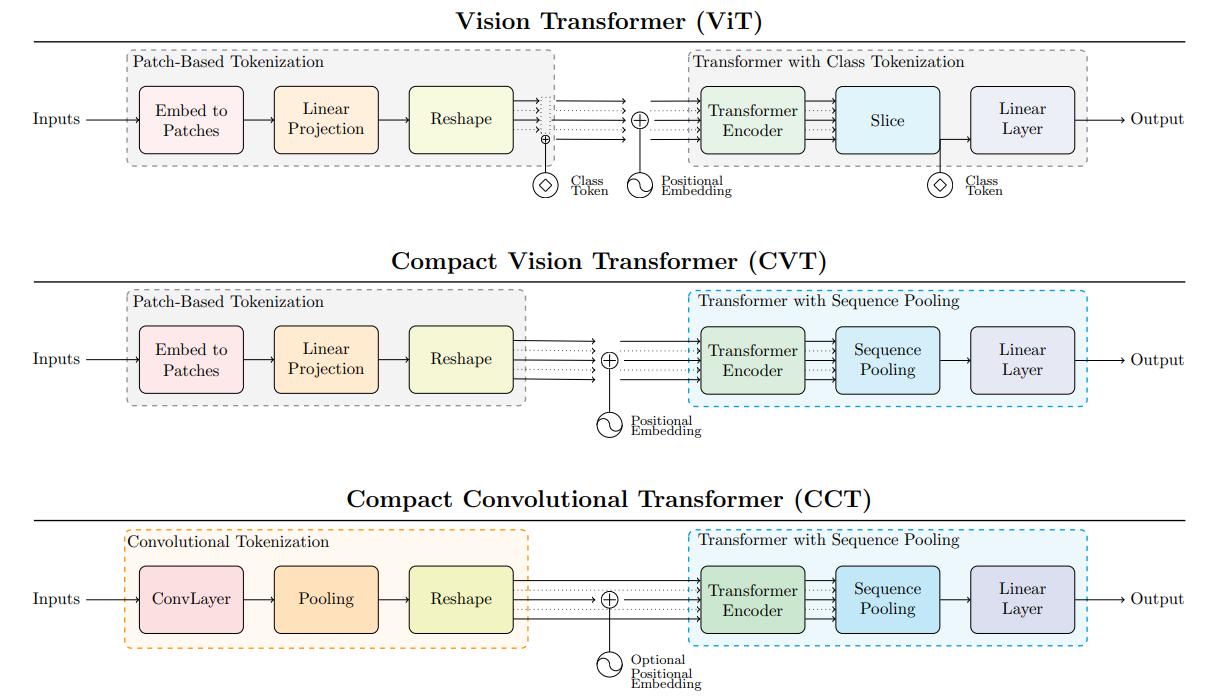

# 준비

## 라이브러리 호출

In [4]:
from tensorflow.keras import layers
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
import numpy as np

## 데이터

In [5]:
num_classes = 10
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 10)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 10)


## 하이퍼 파라미터

In [6]:
positional_emb = True
conv_layers = 2
projection_dim = 128

num_heads = 2
transformer_units = [projection_dim,projection_dim]
transformer_layers = 2
stochastic_depth_rate = 0.1

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 30
image_size = 32

## 증강

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(), #정규화
        layers.Resizing(image_size, image_size), # 사이즈 조절
        layers.RandomFlip("horizontal"), # 수평 뒤집기
        layers.RandomRotation(factor=0.02), # 회전
        layers.RandomZoom(height_factor=0.2, width_factor=0.2) # 확대
    ],
    name="data_augmentation",
)

data_augmentation.layers[0].adapt(x_train)

# 모델링

## The CCT tokenizer

In [ ]:
class CCTTokenizer(layers.Layer):
    def __init__(
        self,
        kernel_size=3,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=2,
        num_conv_layers=conv_layers,
        num_output_channels=[64, 128],
        positional_emb=positional_emb,
        **kwargs,
    ):
        super(CCTTokenizer, self).__init__(**kwargs)

        # This is our tokenizer.
        self.conv_model = keras.Sequential()
        for i in range(num_conv_layers):
            self.conv_model.add(
                layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="valid",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                )
            )
            self.conv_model.add(layers.ZeroPadding2D(padding))
            self.conv_model.add(
                layers.MaxPool2D(pooling_kernel_size, pooling_stride, "same")
            )

        self.positional_emb = positional_emb

    def call(self, images):
        outputs = self.conv_model(images)
        # After passing the images through our mini-network the spatial dimensions
        # are flattened to form sequences.
        reshaped = tf.reshape(
            outputs,
            (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[-1]),
        )
        return reshaped

    def positional_embedding(self, image_size):
        # Positional embeddings are optional in CCT. Here, we calculate
        # the number of sequences and initialize an `Embedding` layer to
        # compute the positional embeddings later.
        if self.positional_emb:
            dummy_inputs = tf.ones((1, image_size, image_size, 3))
            dummy_outputs = self.call(dummy_inputs)
            sequence_length = tf.shape(dummy_outputs)[1]
            projection_dim = tf.shape(dummy_outputs)[-1]

            embed_layer = layers.Embedding(input_dim=sequence_length, output_dim=projection_dim)
            return embed_layer, sequence_length
        else:
            return None